In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json" #&release=2021-06-02"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-06-16


In [4]:
waves = [
    {"start":"2020-08-01", "end":top_date},    
    {},
    {"start":"2020-11-01", "end":"2021-05-01"},    
    {"start":"2021-04-01", "end":top_date}
]

wave = 2
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[13369 27927 22307 20694 20877 20829 16620 17963 28095 24464 24642 21945
 21651 16035 14209 23726 20320 18218 15505 14677 10615 10038 16204 14030
 13932 12277 12263  9208  8906 15030 13515 13465 12526 12884 10143 10870
 17394 16672 17459 18546 19866 16030 18128 29521 29095 30124 29595 31832
 21733 28940 42590 40899 37617 28699 12675 36704 42440 40043 72507 62898
 46679 28221 54167 49514 69109 58039 51315 46827 42334 35443 32858 51997
 44673 41153 38513 36789 27654 26206 40721 35969 31753 28757 26907 19878
 15455 27103 24434 23238 21847 19682 15001 13707 20112 17654 17412 16151
 13971 10582 10134 13836 12241 11841 11224 10563  7742  7533 12465 10814
 10022  9903  8883  6890  6799  9854  8143  7290  6613  5664  4104  3952
  5890  5681  5095  4790  4550  3703  3529  5564  5210  5007  4686  4614
  3448  3584  5437  4740  4853  4521  4138  3369  4518  5141  4336  5106
  4443  3619  2941  4093  3201  2953  3140  2865  2126  2016  1925  2188
  2560  2581  2478  2313  1889  1896  2233  1906  1

In [5]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [6]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = np.zeros(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

outputs = []

In [7]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    outputs.append(pos)

2021-06-20 08:05:20,417 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=109
2021-06-20 08:05:25,734 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109.13703057750224, best pos: [0.00759331 0.01364002 0.00397002 0.00636542 0.0054198  0.00382767
 0.00238305 0.00596038 0.00379758 0.00223851 0.00187776 0.00091892
 0.0027755  0.00509928 0.00167753 0.00090145 0.00146282 0.00151665
 0.00104806 0.00117705 0.00118877 0.00176132 0.00129133 0.00150462
 0.00114443 0.00073856 0.00072312 0.00158093 0.0008226  0.00115899]
2021-06-20 08:05:25,741 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=107
2021-06-20 08:05:30,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 106.56228301355968, best pos: [0.01394485 0.0062

2021-06-20 08:06:29,028 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=113
2021-06-20 08:06:34,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 112.6054959494624, best pos: [0.01251011 0.00621633 0.00451648 0.00454505 0.0025928  0.00586788
 0.00606236 0.00433604 0.00207375 0.00226292 0.00236791 0.00203056
 0.00169621 0.0017795  0.00262382 0.00441512 0.00159532 0.00249158
 0.0015869  0.00098563 0.00100703 0.00122056 0.00155628 0.00063026
 0.00165978 0.00172746 0.00106628 0.00175257 0.00083403 0.0010031 ]
2021-06-20 08:06:34,181 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=102
2021-06-20 08:06:39,340 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 102.40205258328442, best pos: [0.01325863 0.00411

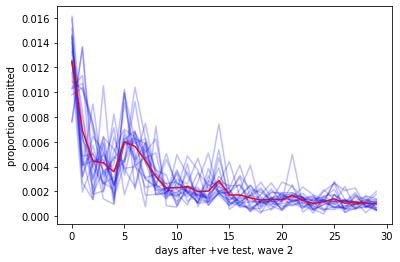

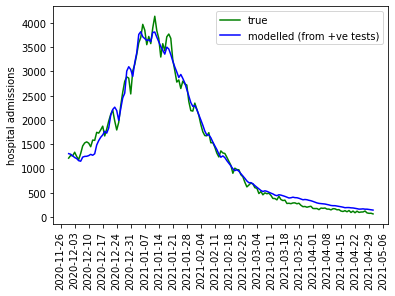

In [8]:
_outputs = np.array(outputs)
plt.clf()
x = list(range(len(pos)))
for y in _outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg = []
for i in range(len(y)):
    y_avg.append(np.mean(_outputs[:,i]))
plt.plot(x, y_avg, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(np.array(y_avg), cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

cases_admiss[wave] = y_avg

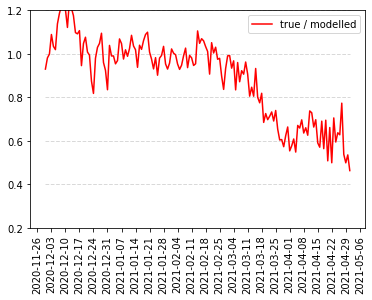

In [11]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.2,1.2)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


2 0.08479432819724624 (7.529130388590864,)


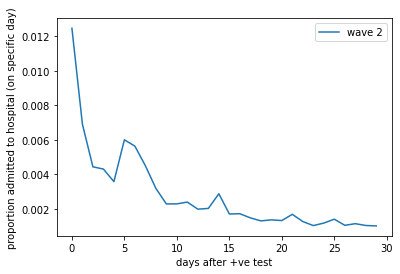

In [12]:
for wave,y_avg in cases_admiss.items():
    print(wave, np.sum(y_avg), center_of_mass(np.array(y_avg[:25])))
          
plt.clf()
x = range(n_dim)
for wave,y_avg in cases_admiss.items():
    plt.plot(x, y_avg, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

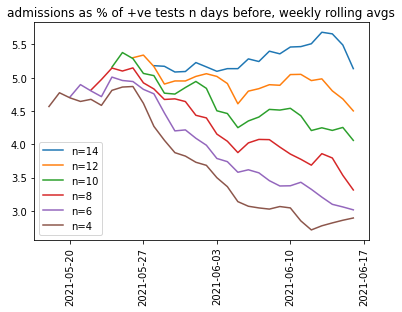

In [13]:
x_dateTimes = df.dateTime.to_list()[-len(x)-11:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [14]:
def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret    

print(_g(np.array([0.5,0.5]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

([1, 2, 3, 4, 5], array([1., 1., 2., 3., 3.]))


In [15]:
n_dim = 30
n_particles = 1000

x_max = np.ones(n_dim)
x_max[0:3] = [1.1,1.1,1.1]
x_min = -0.1*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.90}
bounds = (x_min, x_max)
init_pos = None#np.array([x_min for i in range(n_particles)])

outputs = []

In [16]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    outputs.append(pos)

2021-06-20 08:09:31,759 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=456 
2021-06-20 08:09:37,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 455.75701552508787, best pos: [ 0.78361071  0.7623406   0.90250879  0.34358475  0.56977869  0.63045762
  0.42946205  0.71681954  0.538416    0.58261965  0.32779452  0.5499421
  0.21084983  0.27902062  0.21540428  0.19996523  0.4191887   0.18837288
 -0.04353084  0.28655612  0.18559542  0.07685252 -0.02997368  0.2110704
 -0.0323568   0.14463822 -0.06388842 -0.00214906  0.42631533  0.06003383]
2021-06-20 08:09:37,519 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=383 
2021-06-20 08:09:43,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 383.3086539559481,

2021-06-20 08:10:40,406 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=382 
2021-06-20 08:10:45,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 381.55243900487415, best pos: [ 1.08295632  0.83271324  0.81393743  0.63164697  0.30998409  0.52091436
  0.80799933  0.56132969  0.43330681  0.44031594  0.41634185  0.21847408
  0.3893998   0.4148022   0.22802667  0.03327473  0.55084575  0.03093103
  0.10667558  0.21226986  0.0619515  -0.05844907  0.11781071  0.0298031
  0.08168238 -0.01865912  0.11914835  0.05940757  0.13481003  0.3253058 ]
2021-06-20 08:10:45,987 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=390 
2021-06-20 08:10:51,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 389.5450946258515

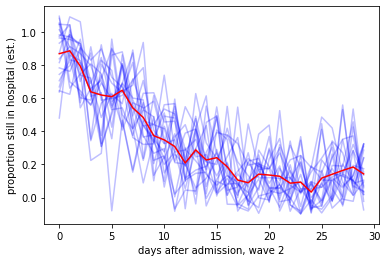

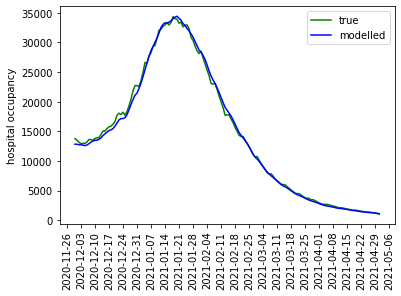

In [17]:
_outputs = np.array(outputs)
plt.clf()
x = list(range(len(pos)))
for y in _outputs:
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg = []
for i in range(len(y)):
    y_avg.append(np.mean(_outputs[:,i]))
plt.plot(x, y_avg, color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital (est.)")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg

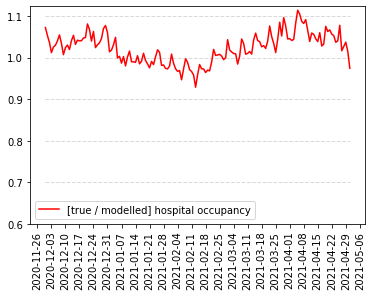

In [19]:
plt.clf()
true, pred = _g(admiss_occup[2], admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="[true / modelled] hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.6,None)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

2 9.839590124029153 (8.584081561686629,)


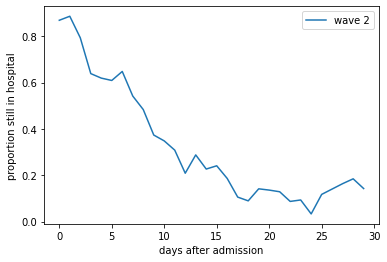

In [20]:
for wave,y_avg in admiss_occup.items():
    print(wave, np.sum(y_avg), center_of_mass(np.array(y_avg)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg in admiss_occup.items():
    plt.plot(x, y_avg, label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()